# Subsetting climate data remotely
This report shows step-by-step guide on how to access climate models data (GCM/RCM) from jupyter notebook using xarray. Since the data can be subset and processed in the cloud, it it much faster than usual data downloading and post processing. 

## Importing packages
The following packages are needed for the analysis. Some packages has to be installed, preferrably in a seperate Anaconda environment.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from cartopy import feature as cf
import requests
import xclim as xc

## Accessing data through ESGF function
ESGF provides a python function that can be used to access climate data from available climate data servers/hosts. As an example, the DRKZ server is used since it hosts most climate models data, including GCMs and RCMs. If needed, one can change the server argument (url) from DRKZ server to any other servers such as LLNL. A full list of servers can be found in this site (https://esgf-data.dkrz.de/projects/esgf-dkrz/). For more infrormation on this function, check this ESGF documentation (https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing). 


In [2]:
def drkz_search(server="http://esgf-data.dkrz.de/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CORDEX",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = [] 
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

With the above function we can filter climate models data, either GCM (CMIP5 and CMIP6) and RCM models. For this analysis, a CMIP6 model is selected. Any parameter inside the function could be changed/removed from search criteria. For example, change project to CMIP5 or CORDEX, change variable_id to tasmin, tasmax or any other desirable variable, similarly apply changes to other parameters. Additional parameters can also be inserted into the search function. Check metadata of a particular data from the DRKZ website for more parameters.  

In [3]:
cmip6 = drkz_search(project = 'CMIP6', variable='pr',  source_id = 'MPI-ESM1-2-HR', experiment_id='hist-1950',frequency="day",variant_label = 'r1i1p1f1')

http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=MPI-ESM1-2-HR&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=MPI-ESM1-2-HR&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=MPI-ESM1-2-HR&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=MPI-ESM1-2-HR&experiment_id=hist-1950&frequency=day&variant_label=r1i1p1f1&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
http://esgf-data.dkrz.de/esg-search/search/?variable=pr&source_id=MPI-ESM1-2-HR&experiment_id=hist-1950&frequency

## Subsetting data to region and time of interest
Now we will read the netcdf files from urls, extract data according to defined boundary and variable, change the unit as desired, the number of urls (netcdf files) to process. Each url most probably store five years of data, so this will be in a away defining data period. Change the number of file for a given period of interest. We suggest to print all urls (e.g. print(cmip5) so that you can decide which files to obtain. It is also recommended to open a single url file in xarray and explore metadata by printing the data, which will help define this input parameters (lat, lon, pr). 

In [4]:
#Define clip boundary, no of files (period), and units for data
y=slice(-20,60) #Define latitue range.
x=slice(10,140) #Define longitude range.
n=4 #no of files/urls to process starting from latest
var='pr' #Check metadata of data, change this name (pr) if needed.
unit = 'mm/day' #Define the unit for which data to be changed into.


ds = []
for i in cmip6[len(cmip6)-n:len(cmip6)+1]:
    data = xr.open_dataset(i)
    data=data.sel(lat=y,lon=x) #check metadata of data, change this name (lon/lat) if needed.
    ds.append(data)

ds = xr.concat(ds, dim='time')
ds = xc.units.convert_units_to(ds[var], unit) 

## Visualizing data
Now we plot data both spatially and temporally for demonstration. The following script will plot precipitation data at first time instance along the longitude and latitue. Successively, you will see how to extract data from a single coordinate and plot time series. 

/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/farid/Abaconda3/anaconda3/envs/geo_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


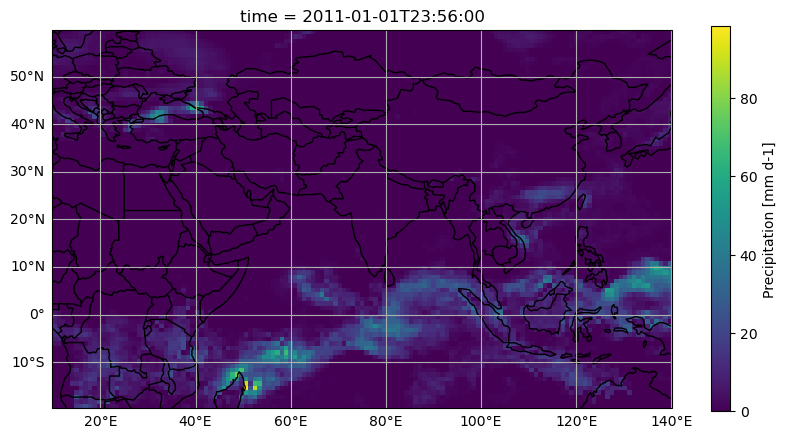

In [5]:
#plot the first element of processed data along lon and lat dimensions
fig, ax=plt.subplots(figsize=(10, 5),subplot_kw={'projection':ccrs.PlateCarree()})
ds[0,:,:].plot(ax=ax)
ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_feature(cf.LAND)
ax.add_feature(cf.OCEAN)
gl=ax.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False

Below will show how to extract data from a given coordinate and plot it. One can also define a list of coordinates (multiple points). This will extract data from the closest grid (center) to the defined point/points.  

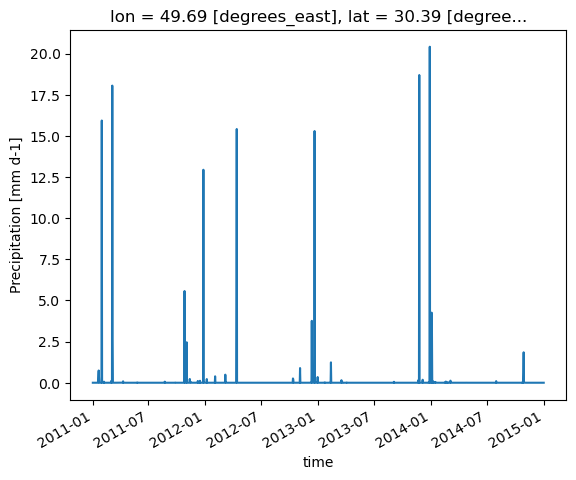

In [6]:
#Define coordinate (or coordinates by passing a list) for data extraction
x=50 #lon of interest.
y=30 #lat of interest.

time_series_data=ds.sel(lon=x, lat=y, method='nearest')
time_series_data.plot()

```{hint} One can save these plots to a local drive by typing (plt.savefig('Directory to save figure/its name.png'). This code should be typed at the end where you already defined the plot/figure. 
```

## Exporting data to csv
Using the previous datasets, we will extract time series data from a list of coorindates and then export it to a csv format. Also, stacking is required for multiple coordinates. In case of one point no need to stack data. 

In [7]:
x=[80,82,86] #lon of interest.
y=[40,42,45] #lat of interest.

my_data=ds.sel(lon=x, lat=y, method='nearest')

#Stack along the lon and lat to remove empty lon,lat, then change data data to pandas, dataframe and save to csv.
my_data = my_data.stack(coordinates=('lon','lat'))
my_data = my_data.to_pandas()
my_data = pd.DataFrame(my_data)
my_data

lon                       79.6875                                   81.5625  \
lat                     39.740099     41.610218     45.350454     39.740099   
time                                                                          
2011-01-01 23:56:00  5.733222e-03  1.717049e-01  1.201739e-13  1.508743e-05   
2011-01-02 23:56:00  7.332488e-03  8.539483e-03  8.459017e-03  5.833805e-04   
2011-01-03 23:56:00  1.550328e-13  7.015653e-03  1.550328e-13  1.550328e-13   
2011-01-04 23:56:00  1.293403e-13  1.293403e-13  1.293403e-13  1.293403e-13   
2011-01-05 23:56:00  1.226772e-13  3.218651e-04  4.038321e+00  1.226772e-13   
...                           ...           ...           ...           ...   
2014-12-27 23:56:00  1.246169e-13  1.246169e-13  1.423247e-03  1.246169e-13   
2014-12-28 23:56:00  1.235943e-13  1.235943e-13  1.235943e-13  1.235943e-13   
2014-12-29 23:56:00  1.198839e-13  2.514571e-05  4.018687e-01  1.198839e-13   
2014-12-30 23:56:00  1.246460e-13  3.520399e-05  1.353654e+00  1.246460e-13   
2014-12-31 23:56:00  1.213671e-13  1.285851e-01  4.835520e-02  1.213671e-13   

lon                                                   86.2500                \
lat                     41.610218     45.350454     39.740099     41.610218   
time                                                                          
2011-01-01 23:56:00  7.035870e-01  1.005828e-05  2.997369e-03  8.212589e-03   
2011-01-02 23:56:00  2.061646e-01  9.464543e-01  2.011657e-05  1.193316e-13   
2011-01-03 23:56:00  4.274771e-04  3.771857e-04  1.550328e-13  1.550328e-13   
2011-01-04 23:56:00  1.293403e-13  1.293403e-13  1.293403e-13  1.293403e-13   
2011-01-05 23:56:00  1.226772e-13  9.283795e-02  1.226772e-13  1.226772e-13   
...                           ...           ...           ...           ...   
2014-12-27 23:56:00  1.246169e-13  1.246169e-13  1.246169e-13  1.246169e-13   
2014-12-28 23:56:00  1.235943e-13  1.235943e-13  1.235943e-13  1.235943e-13   
2014-12-29 23:56:00  1.198839e-13  3.190488e-02  1.198839e-13  1.198839e-13   
2014-12-30 23:56:00  1.005828e-05  8.061312e-01  1.246460e-13  1.246460e-13   
2014-12-31 23:56:00  2.011657e-05  1.535799e-01  1.137089e-02  8.348375e-04   

lon                                
lat                     45.350454  
time                               
2011-01-01 23:56:00  1.201739e-13  
2011-01-02 23:56:00  1.193316e-13  
2011-01-03 23:56:00  1.550328e-13  
2011-01-04 23:56:00  1.293403e-13  
2011-01-05 23:56:00  1.226772e-13  
...                           ...  
2014-12-27 23:56:00  5.029142e-06  
2014-12-28 23:56:00  1.235943e-13  
2014-12-29 23:56:00  1.198839e-13  
2014-12-30 23:56:00  1.246460e-13  
2014-12-31 23:56:00  1.213671e-13  

[1461 rows x 9 columns]